# fMRI data decoding
Decoding is the process of eliciting the activation signal from fMRI data. It entails the prediction of signal from brain images. Prediction and classification tend to go hand in hand and this makes MLPs suitable for this purpose. Other classifiers that are commonly used are SVCs which tend to perform quite well for Decoding small datasets but as we get into the realm of big data, Neural Networks tend to be more efficient and easier to train. In this section, we will redo the Decoding that was data in the nilearn intro below but in lieu of making use of an SVC, we will use Neural networks.
https://nilearn.github.io/decoding/decoding_intro.html

## Haxby Experiment: Category Classification


In the Haxby experiment, subjects were presented visual stimuli from different categories. We are going to predict which category the subject is seeing from the fMRI activity recorded in masks of the ventral stream. Significant prediction shows that the signal in the region contains information on the corresponding category.

nilearn is 

We will make use of nilearn to load the data as guided by the tutorial above, an use nilearn.input_data.NiftiMasker to extract only the voxels on the mask of the ventral temporal cortex. 

## Download and Load the dataset

In [1]:
%matplotlib inline
#Import nilearn and load the haxby dataset.
import warnings
warnings.filterwarnings('ignore')
from nilearn import datasets
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print(f'First subject functional nifti images (4D) are at: {fmri_filename}')  # 4D data

/Users/brianwahome254/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


First subject functional nifti images (4D) are at: /Users/brianwahome254/nilearn_data/haxby2001/subj2/bold.nii.gz


## Display the dataset

Notice that the stimuli in this experiment was all visual hence why all the activation is in the visual cortex

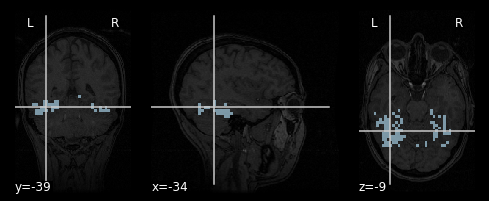

In [2]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
from nilearn import plotting
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],cmap='Paired')

In [3]:
#Mask to select features
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, standardize=True)

# We give the masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_filename)

## Stimuli (Labels)
The key to the experiment is the exposure of the subjects to different visual stimuli be it cat pictures, scissor pictures among others. We use a pandas dataframe to illustrate the different stimuli the individuals were exposed to at different timepoints. We will filter the data to make use of the face and cat data only. In doing this, all non cat data will be labelled False, while cat activations will be True, setting the scene for classification.

In [4]:
import pandas as pd
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']
condition_mask = conditions.isin(['cat'])

# We apply this mask in the sampe direction to restrict the
# classification to the face vs cat discrimination
#This will be the data we work with. 
fmri_cats = fmri_masked[condition_mask]

# Decoding using a CNN

Now let us get to the fun stuff, we will now create a CNN using Keras, feeding it the voxel activations for faces and cats stored in _fmri_masked_face_cats_ and the labels stored in _condition_mask_face_cats_ . We will then make use of the neural network to predict labels on unlabelled data. By labelling, __we mean categorizing the stimuli from the voxel activation__.

We will compare our results to that from an SVC decoding as done in the main tutorial.

## import required packages

In [5]:
#Uncomment to install required packages if not installed
#!pip install keras tensorflow
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

Using TensorFlow backend.


# The first step when creating a CNN is specifying the model. 

What does the sequential package do? What is Activation for? Why are the dense layers? Why are they called dense?
Why on earth are we using an optimizer?






1) Create a sequential model.

In [6]:
model = Sequential()


2) Add an input Dense layer, __specifying the activation function as 'relu'.__ and the number of voxels per timepoint. Note: The number of rows (number of training samples) is not the part of the input shape of the network because the training process feeds the network one sample per batch (or, more precisely, batch_size samples per batch) hence why we just use the second value of the input when specifying the shape


In [7]:
input_shape = (fmri_masked.shape[1],)
print(f'Input shape: {input_shape}')
model.add(Dense( 20,input_shape = input_shape , activation='relu'))

Input shape: (464,)



3) __Using a  for loop, ADD 5 more layers with half the number of nodes as the input layer__

In [8]:
num_layers = 5
for _ in range(num_layers):
    model.add(Dense(10 ,activation='relu'))

4) Add a final layer with __as many nodes as the number of categories we have in our labels__. The activation function for the last layer should be 'softmax'

In [9]:
categories = set(condition_mask)
print(f'Our categories: {categories}')
model.add(Dense( len(categories),activation='relu'))

Our categories: {False, True}


5) Compile the model, __use the Adam optimizer with sparse_categorical_cross_entropy as the loss function. Set the learning rate to 0.0001 and have metrics listed as ['accuracy']__ to have the performance automatically output.

In [10]:
model.compile(optimizer = Adam(lr = .0001), metrics = ["accuracy"], loss = "sparse_categorical_crossentropy")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                9300      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

# Training the model

To train the model, we will split our data into training and testing sets. You have the option to have a cross validation set using the inbuild keras parameter, validation split which in our case will be .1 giving us a training, validation testing split of 60-10-30 split.

In [11]:
print(len(condition_mask),len(fmri_masked))
split = int(len(fmri_masked)*.7)
training_data, training_labels = fmri_masked[:split], condition_mask[:split]
testing_data, testing_labels = fmri_masked[split:], condition_mask[split:]

1452 1452


6) Fit the training data and labels to the model with a __batch size of 10. Have 30 epochs and shuffle to True__, verbose = 3

In [12]:
model.fit(training_data, training_labels, batch_size = 10, validation_split=0.1, epochs=30, shuffle = True, verbose = 2)

Train on 914 samples, validate on 102 samples
Epoch 1/30
 - 0s - loss: 0.9540 - accuracy: 0.9311 - val_loss: 1.7329 - val_accuracy: 0.8235
Epoch 2/30
 - 0s - loss: 0.8050 - accuracy: 0.9311 - val_loss: 1.7399 - val_accuracy: 0.8235
Epoch 3/30
 - 0s - loss: 0.7821 - accuracy: 0.9311 - val_loss: 1.8197 - val_accuracy: 0.8235
Epoch 4/30
 - 0s - loss: 0.7432 - accuracy: 0.9311 - val_loss: 1.8078 - val_accuracy: 0.8235
Epoch 5/30
 - 0s - loss: 0.6655 - accuracy: 0.9311 - val_loss: 1.8048 - val_accuracy: 0.8235
Epoch 6/30
 - 0s - loss: 0.6554 - accuracy: 0.9311 - val_loss: 1.7975 - val_accuracy: 0.8235
Epoch 7/30
 - 0s - loss: 0.6496 - accuracy: 0.9311 - val_loss: 1.7915 - val_accuracy: 0.8235
Epoch 8/30
 - 0s - loss: 0.6331 - accuracy: 0.9311 - val_loss: 1.7827 - val_accuracy: 0.8235
Epoch 9/30
 - 0s - loss: 0.5543 - accuracy: 0.9322 - val_loss: 1.7772 - val_accuracy: 0.8235
Epoch 10/30
 - 0s - loss: 0.5313 - accuracy: 0.9365 - val_loss: 1.7631 - val_accuracy: 0.8235
Epoch 11/30
 - 0s - los

# Making Predictions

Not so bad eh? The model has sensible accuracies and can probably be fine tuned to do better but for now, let us make category predictions. We want to determine whether any new activation we get was from a cat or something else. We also compare the predictions to the actual values to get our model performance using a confusion matrix.

In [13]:
category_predictions = model.predict_classes(testing_data)

In [14]:
from sklearn.metrics import accuracy_score
print(f"Accuracy Score: {accuracy_score(category_predictions, testing_labels)}")

Accuracy Score: 0.9311926605504587


We are able to tell when an activation is from a cat image or not. This is done directly from data that has been modified to fit

# CNN. 

While I was able to convert MRI data to PNG, mapping the labels to the slices was something I was unable to figure out thus i opted to focus on getting us rollowing with a non fmri dataset. We will keep things simple by going with MNIST to get a gist of how to implement CNNs and RNNSs. The Categorization of images to their respective labels should be analogous to the categorization of activations to the stimuli. Conversion of fmri datasets to png is possible using toos like 

# Import Extra Packages

We need to import some extra layers we will be making use of for the CNN and the Keras backend for data formatting.
I preload and split the data into training and testing sets to allow us to focus on the implementation of the model

In [61]:
#Adapted from https://keras.io/examples/mnist_cnn/
from keras.datasets import mnist
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28
propotion = .10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_lim, test_lim = int(len(x_train)*propotion), int(len(x_test)*propotion)
x_train, y_train, x_test, y_test = x_train[:train_lim], y_train[:train_lim], x_test[:test_lim], y_test[:test_lim]
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"Training data dimensions: {input_shape}")

x_train shape: (6000, 28, 28, 1)
6000 train samples
1000 test samples
Training data dimensions: (28, 28, 1)


1) Create an instance of the Sequetial model.

In [ ]:
model = Sequential()

2) Add a Conv2D layer with 32 units, activation relu and the input shape as appropriate given the training data dimensions above.

In [ ]:
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

3) Add a second Conv2D layer with 64 units. 
Why dont we specify the input shape for the second layer?

Add 3 more layers, a MaxPooling layer, Dropout layer, 

A Flatten() layer and a normal Dense layer. 

What does these layers each do? Whats the difference between them?

Refer to the keras layers documentation here: 

https://keras.io/layers/convolutional/

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

4) Add the output layer. Specify the number of classes for this layer.

In [ ]:
model.add(Dense(num_classes, activation='softmax'))

5) Compile the model

In [56]:
model.compile(loss=['categorical_crossentropy'],optimizer=Adam(lr = .0001),metrics=['accuracy'])

6) Fit data and validate the model using the validation_data parameter which takes a tupple of the test data and labels and validates the model. This automates the prediction step we took in the first Neural Network.

i.e __validation_data=(x_test, y_test))__

In [58]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split =0.1,
          
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 6000 samples, validate on 1000 samples
Epoch 1/12
 - 5s - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0779 - val_accuracy: 0.9750
Epoch 2/12
 - 5s - loss: 0.0147 - accuracy: 0.9950 - val_loss: 0.0799 - val_accuracy: 0.9730
Epoch 3/12
 - 5s - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0764 - val_accuracy: 0.9750
Epoch 4/12
 - 5s - loss: 0.0165 - accuracy: 0.9943 - val_loss: 0.0801 - val_accuracy: 0.9720
Epoch 5/12
 - 5s - loss: 0.0148 - accuracy: 0.9962 - val_loss: 0.0793 - val_accuracy: 0.9730
Epoch 6/12
 - 5s - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0796 - val_accuracy: 0.9800
Epoch 7/12
 - 5s - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.0786 - val_accuracy: 0.9750
Epoch 8/12
 - 5s - loss: 0.0122 - accuracy: 0.9970 - val_loss: 0.0817 - val_accuracy: 0.9750
Epoch 9/12
 - 5s - loss: 0.0126 - accuracy: 0.9967 - val_loss: 0.0814 - val_accuracy: 0.9780
Epoch 10/12
 - 5s - loss: 0.0124 - accuracy: 0.9952 - val_loss: 0.0784 - val_accuracy: 0.9740
Epoch 11/12
 - 5s - l

# RNN

We will take a bit an opposite approach here and try to understand what ia happening in this code.

In [64]:
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM

Code review: What does each line do?

In [68]:
# Training parameters.
batch_size = 32
num_classes = 10
epochs = 5

# Embedding dimensions.
row_hidden = 128
col_hidden = 128

# The data, split between train and test sets.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_lim, test_lim = int(len(x_train)*propotion), int(len(x_test)*propotion)
x_train, y_train, x_test, y_test = x_train[:train_lim], y_train[:train_lim], x_test[:test_lim], y_test[:test_lim]

# Reshapes data to 4D for Hierarchical RNN.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converts class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

row, col, pixel = x_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training.
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split = .1,
          validation_data=(x_test, y_test))

# Evaluation.
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


x_train shape: (6000, 28, 28, 1)
6000 train samples
1000 test samples
Train on 6000 samples, validate on 1000 samples
Epoch 1/5
 - 46s - loss: 1.3928 - accuracy: 0.5170 - val_loss: 1.3322 - val_accuracy: 0.5460
Epoch 2/5
 - 45s - loss: 0.7276 - accuracy: 0.7562 - val_loss: 0.6436 - val_accuracy: 0.7710
Epoch 3/5
 - 43s - loss: 0.5210 - accuracy: 0.8298 - val_loss: 0.4792 - val_accuracy: 0.8270
Epoch 4/5
 - 43s - loss: 0.3928 - accuracy: 0.8745 - val_loss: 0.3749 - val_accuracy: 0.8840
Epoch 5/5
 - 43s - loss: 0.2981 - accuracy: 0.9063 - val_loss: 0.3117 - val_accuracy: 0.9000
Test loss: 0.3117322905063629
Test accuracy: 0.8999999761581421
